<a href="https://colab.research.google.com/github/jiaminho/RPH-HAC-Prediction/blob/jiamin_branch/HAC_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hospital Acquired Complications (HACs) Model Training and Evaluation

### Install and import libraries

In [1]:
%%capture
# Installing Packages
!pip install umap-learn
!pip install bokeh
!pip install shap
!pip install bokeh holoviews colorcet scikit-image datashader
!pip install optuna
!pip install optuna-integration

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.gridspec as gridspec
import shap
import umap
import umap.plot
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, confusion_matrix, balanced_accuracy_score, roc_curve, auc
from sklearn.calibration import calibration_curve
from sklearn.cluster import AgglomerativeClustering
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import xgboost as xgb
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, LearningRateScheduler
import warnings
import optuna
from optuna.integration import TFKerasPruningCallback
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, balanced_accuracy_score


pd.set_option('display.max_columns', None)  # None ensures all columns are shown
warnings.simplefilter(action='ignore', category=FutureWarning)

### Read Preprocessed Data

In [3]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import pandas as pd

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Download the file
file_id = '1oytLt6WKLGciX1W34zBkwQ-9CBWtFe-d'
file_name = 'selected_features_80.csv'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile(file_name)

# Read into DataFrame
selected_features_data = pd.read_csv(file_name)
selected_features_data.shape

(58976, 81)

In [4]:
selected_features_data.head()

,Procedure: Surgical Suture and Repair,"Creatine Kinase, MB Isoenzyme",Bands,Lipase,Iron,Procedure: Facial and Thoracic Surgery,"Bilirubin, Total",Procedure: Cranial and Peripheral Interventions,Eosinophils,"Fibrinogen, Functional",ADMISSION_TYPE_ELECTIVE,"Chloride, Whole Blood",Procedure: External Device and Eyelid Repair,"Iron Binding Capacity, Total",Red Blood Cells,Procedure: Gastric Procedure and Vascular Revision,"Sodium, Whole Blood",Monocytes,Transferrin,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,Hematocrit,Procedure: Spinal and Abdominal Surgery,Vancomycin,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Alanine Aminotransferase (ALT),Procedure: Structural and Bone Biopsy,Procedure: Lung Biopsy and Intervention,"Potassium, Whole Blood",ADMISSION_TYPE_NEWBORN,Lactate Dehydrogenase (LD),pCO2,Urobilinogen,pO2,Procedure: Arterial Imaging and Debridement,pH,Anion Gap,Asparate Aminotransferase (AST),Free Calcium,Calculated Total CO2,ETHNICITY_WHITE,PT,Alkaline Phosphatase,Lactate,DIAGNOSIS_NEWBORN,Procedure: Knee and Spinal Surgery,MCV,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,White Blood Cells,Hyaline Casts,Platelet Count,MCH,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,RDW,MCHC,INR(PT),Magnesium,Creatine Kinase (CK),Neutrophils,Lymphocytes,Bicarbonate,Procedure: Injections and Therapeutic Procedures,"Calcium, Total",Glucose,Potassium,PTT,Procedure: Catheterization and Ventilation Techniques,Troponin T,Procedure: Contrast Imaging and Spleen Procedures,Phosphate,Chloride,Sodium,Albumin,Creatinine,GENDER_F,Urea Nitrogen,GENDER_M,ADMISSION_TYPE_EMERGENCY,AGE_AT_ADMISSION,RBC,WBC,uti
0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0,1.0,1.0,1.0,0,1.0,0.0,0.0,1.0,0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1,1.0,1.0,1.0,0,1.0,1.0,0,1.0,0.0,1.0,1.0,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0,1.0,1,1,63.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,1.0,0.0,0,1.0,1.0,0,1.0,0.0,1.0,1.0,1,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0,1.0,1,1,64.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0.0,0.0,0.0,0,0.0,1.0,0,1.0,1.0,0.0,0.0,1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1,1.0,0,1,85.0,1.0,1.0,1.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1,1.0,0.0,1.0,0,0.0,1.0,0.0,0.0,0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1.0,0.0,0.0,0,0.0,0.0,0,1.0,0.0,0.0,0.0,0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1,1.0,0,1,59.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,1.0,2.0,0.0,0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1,1.0,0.0,0.0,0,0.0,1.0,0,0.0,0.0,0.0,1.0,1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1,1.0,0,1,87.0,1.0,0.0,1.0


In [5]:
selected_features_data['uti'].value_counts()

0.0    52421
1.0     6555
Name: uti, dtype: int64

In [6]:
selected_features_data['uti'] = selected_features_data['uti'].replace({True: 1, False: 0})

In [7]:
selected_features_df = selected_features_data

In [8]:
#selected_features_df = selected_features_data.drop(['HADM_ID'], axis=1)

### Train Test Val Split

In [9]:
X = selected_features_df.drop('uti', axis=1)
y = selected_features_df['uti']

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [10]:
# Scale data
StdScaler = StandardScaler()
X_train_scaled = StdScaler.fit_transform(X_train)
X_val_scaled = StdScaler.transform(X_val)
X_test_scaled = StdScaler.transform(X_test)

**Functions for Model Evaluation**

In [11]:
def evaluate_classification(model, X, y):
    # Get probabilities and predictions based on the type of model
    try:
        probabilities = model.predict_proba(X)[:, 1]  # This will work for Scikit-learn, XGBoost, LightGBM
        predictions = model.predict(X)
    except AttributeError:
        probabilities = model.predict(X).flatten()  # This will work for Keras
        predictions = (probabilities > 0.5).astype(int)

    # Calculate AUC
    auc = roc_auc_score(y, probabilities)

    # Calculate confusion matrix for Sensitivity and Specificity
    tn, fp, fn, tp = confusion_matrix(y, predictions).ravel()

    # Sensitivity (Recall)
    sensitivity = tp / (tp + fn)

    # Specificity
    specificity = tn / (tn + fp)

    # Accuracy
    accuracy = accuracy_score(y, predictions)

    # Balanced Accuracy
    balanced_acc = balanced_accuracy_score(y, predictions)

    metrics = {
        'AUC': auc,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc
    }

    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value:.2f}")


def plot_learning_curves(history):
    # Extract the training and validation losses & accuracies
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    train_acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(train_loss) + 1)

    plt.figure(figsize=(12, 4))

    # Plot training and validation accuracies
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot training and validation losses
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# define labels
labels = ['non-UTI', 'UTI']

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.show()

**Function for SHAP**

### Neural Network + Encoder + UMAP

 DNN for binary classification that also provide an encoding of the input through model_encoder

In [12]:
# Define the neural network architecture
def build_model(input_shape):
    x = inp = Input(shape=input_shape)

    # Create hidden layers
    for _ in range(3):
        x = Dense(64, activation='swish')(x)
        x = Dropout(0.2)(x)

    out_encoder = Dense(64)(x)
    out = Dense(1, activation='sigmoid')(x)

    return Model(inputs=inp, outputs=out), Model(inputs=inp, outputs=out_encoder)

# Compute sample weights for class balancing
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Define callbacks
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)

# Create and compile the model
model, model_encoder = build_model([80])
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64,
                    validation_data=(X_val_scaled, y_val),
                    sample_weight=sample_weights,
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 9s 5ms/step - loss: 0.5111 - accuracy: 0.7237 - val_loss: 0.4504 - val_accuracy: 0.7731 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 3s 4ms/step - loss: 0.4749 - accuracy: 0.7512 - val_loss: 0.4729 - val_accuracy: 0.7563 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 3s 4ms/step - loss: 0.4651 - accuracy: 0.7505 - val_loss: 0.4502 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4628 - accuracy: 0.7561 - val_loss: 0.4620 - val_accuracy: 0.7655 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4574 - accuracy: 0.7592 - val_loss: 0.4796 - val_accuracy: 0.7579 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4521 - accuracy: 0.7570 - val_loss: 0.4642 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [13]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)
print(classification_report(y_test, dnn_y_test_pred.round()))

1180/1180 [==============================] - 2s 1ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.32      0.78      0.45      1333

    accuracy                           0.79     11796
   macro avg       0.64      0.78      0.66     11796
weighted avg       0.89      0.79      0.82     11796



In [14]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.31% - Balanced accuracy Test
82.04% - Balanced accuracy Train


In [22]:
evaluate_classification(model, X_test_scaled, y_test)

369/369 [==============================] - 0s 1ms/step
AUC: 0.85
Sensitivity: 0.78
Specificity: 0.79
Accuracy: 0.79
Balanced Accuracy: 0.78


**UMAP and Agglomerative clustering**

- Use a pre-trained model encoder to transform the training and testing data (X_train_scaled_new and X_test_scaled_new).
- Apply UMAP (Uniform Manifold Approximation and Projection) dimensionality reduction to the encoded test data.
- Use agglomerative clustering on the encoded test data.
- Identify clusters that contain prediction errors and summarizes these errors.
- Visualize the data points in the 2D UMAP space, highlighting errors and true labels.

In [18]:
# Using a Pre-trained Model Encoder to Transform Data
Xenc_train = model_encoder(X_train_scaled).numpy()
Xenc_test = model_encoder(X_test_scaled)

# Applying UMAP Dimensionality Reduction
reducer = umap.UMAP(n_components=2, random_state=42)
embedding = reducer.fit_transform(Xenc_test)

# Model Prediction
y_pred = model(X_test_scaled).numpy().round()

# Fitting UMAP to Test Data
mapper = umap.UMAP().fit(Xenc_test)

# Applying Agglomerative Clustering
cluster = AgglomerativeClustering(metric="cosine", distance_threshold=0.5, n_clusters=None, linkage='average')
cluster_test = cluster.fit_predict(Xenc_test.numpy())

# Identifying Errors
error = [cluster_test[ix] for ix in range(len(y_pred[:,0])) if (not y_pred[ix,0] == y_test.values[ix]) and  y_pred[ix,0] == 1]
print(Counter(cluster_test).most_common(10))
print(Counter(error).most_common(10))

n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.


[(22, 6644), (188, 1225), (12, 470), (41, 380), (64, 371), (92, 219), (79, 184), (2, 180), (45, 147), (72, 105)]
[(188, 718), (41, 294), (64, 221), (79, 149), (92, 147), (72, 74), (28, 69), (0, 53), (88, 26), (42, 20)]


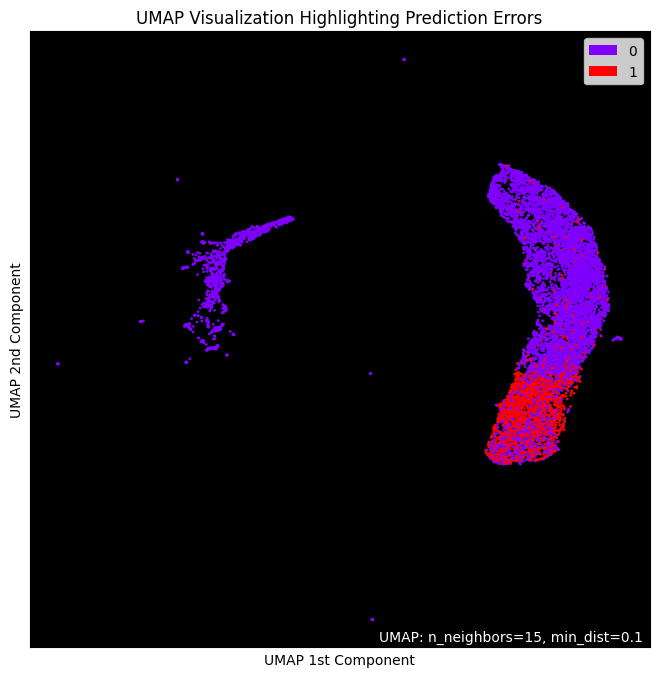

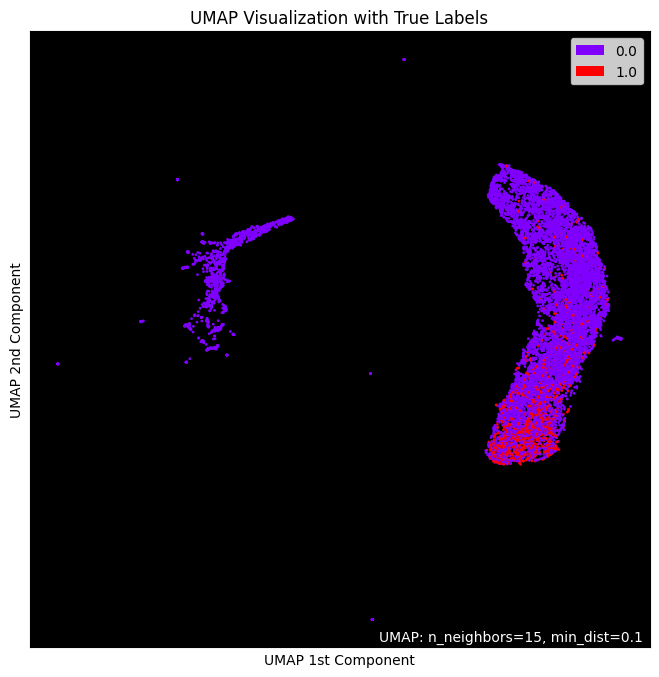

In [19]:
# Error and Label Lists
errors = [0 if y_pred[ix,0] == y_test.values[ix] else 1 for ix in range(len(y_pred[:,0]))]
labels = [y_test.values[ix] for ix in range(len(y_pred[:,0]))]

# Visualization using UMAP
umap.plot.points(mapper, labels=np.array(errors), theme='fire')
plt.gca().set_title('UMAP Visualization Highlighting Prediction Errors')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

umap.plot.points(mapper, labels=np.array(labels), theme='fire')
plt.gca().set_title('UMAP Visualization with True Labels')
plt.xlabel('UMAP 1st Component')
plt.ylabel('UMAP 2nd Component')
plt.show()

Permutation Importance

In [23]:
def permutation_importance(model, X_val_scaled, y_val, metric=accuracy_score):
    """
    Calculate permutation importance for a given model and validation set.

    Parameters:
    - model: Trained model
    - X_val: Validation data (features)
    - y_val: True labels for validation data
    - metric: Performance metric function

    Returns:
    - importances: Feature importance scores
    """
    feature_names = X.columns.tolist()

    # Get the original performance of the model
    original_preds = model.predict(X_val_scaled)
    # Convert predictions to binary values
    original_preds_binary = (original_preds > 0.5).astype(int)
    original_score = metric(y_val, original_preds_binary)

    # Calculate permutation importance for each feature
    importances = []
    for col in range(X_val_scaled.shape[1]):
        X_val_copy = X_val_scaled.copy()
        np.random.shuffle(X_val_copy[:, col])
        shuffled_preds = model.predict(X_val_copy, verbose=0)
        shuffled_preds_binary = (shuffled_preds > 0.5).astype(int)
        shuffled_score = metric(y_val, shuffled_preds_binary)
        importances.append(original_score - shuffled_score)

    return np.array(importances)

feature_names = X.columns.tolist()

# Calculate permutation importance
feature_importances = permutation_importance(model, X_val_scaled, y_val)

# Pair feature names with their importances
feature_importance_pairs = list(zip(feature_names, feature_importances))

# Sort feature importances in descending order
sorted_feature_importance_pairs = sorted(feature_importance_pairs, key=lambda x: x[1], reverse=True)

# Display feature importances in descending order
for name, imp in sorted_feature_importance_pairs:
    print(f"Feature {name}: {imp}")


295/295 [==============================] - 0s 1ms/step
Feature WBC: 0.06093683764306901
Feature ADMISSION_LOCATION_EMERGENCY ROOM ADMIT: 0.005510809665112304
Feature RBC: 0.005298855447223305
Feature ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM: 0.0037091988130563136
Feature Free Calcium: 0.0036032217041118697
Feature pO2: 0.003497244595167426
Feature Fibrinogen, Functional: 0.003285290377278427
Feature MCHC: 0.0029673590504450953
Feature Urobilinogen: 0.0027554048325560965
Feature ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE: 0.0026494277236116526
Feature Asparate Aminotransferase (AST): 0.0024374735057227648
Feature AGE_AT_ADMISSION: 0.002225519287833766
Feature Sodium, Whole Blood: 0.002119542178889322
Feature Procedure: Spinal and Abdominal Surgery: 0.002119542178889322
Feature Lactate Dehydrogenase (LD): 0.002119542178889322
Feature Hyaline Casts: 0.002119542178889322
Feature GENDER_F: 0.0019075879610004343
Feature Calculated Total CO2: 0.0018016108520558793
Feature MCH: 0.0018016

## Deep Neural Network (DNN)

In [24]:
# Compute sample weights
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Performance Scheduling
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# early stopping
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)


model = Sequential()
model.add(Dense(64, input_shape=(X_train_scaled.shape[1],), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])
history = model.fit(X_train_scaled, y_train, epochs=100, batch_size=64, sample_weight=sample_weights, validation_data=(X_val_scaled, y_val),
                    callbacks=[early_stopping, lr_scheduler])

Epoch 1/100
590/590 [==============================] - 4s 4ms/step - loss: 0.5593 - accuracy: 0.6794 - val_loss: 0.4671 - val_accuracy: 0.7511 - lr: 0.0010
Epoch 2/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4943 - accuracy: 0.7351 - val_loss: 0.4763 - val_accuracy: 0.7510 - lr: 0.0010
Epoch 3/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4826 - accuracy: 0.7391 - val_loss: 0.4670 - val_accuracy: 0.7559 - lr: 0.0010
Epoch 4/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4693 - accuracy: 0.7444 - val_loss: 0.4913 - val_accuracy: 0.7397 - lr: 0.0010
Epoch 5/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4663 - accuracy: 0.7430 - val_loss: 0.4788 - val_accuracy: 0.7476 - lr: 0.0010
Epoch 6/100
590/590 [==============================] - 2s 4ms/step - loss: 0.4598 - accuracy: 0.7441 - val_loss: 0.4681 - val_accuracy: 0.7620 - lr: 0.0010
Epoch 7/100
590/590 [==============================] - 2s 4ms/st

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 64)                5184      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 32)                2080      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 16)                528       
                                                                 
 dropout_5 (Dropout)         (None, 16)                0         
                                                                 
 dense_8 (Dense)             (None, 1)                 1

Plot Learning Curves

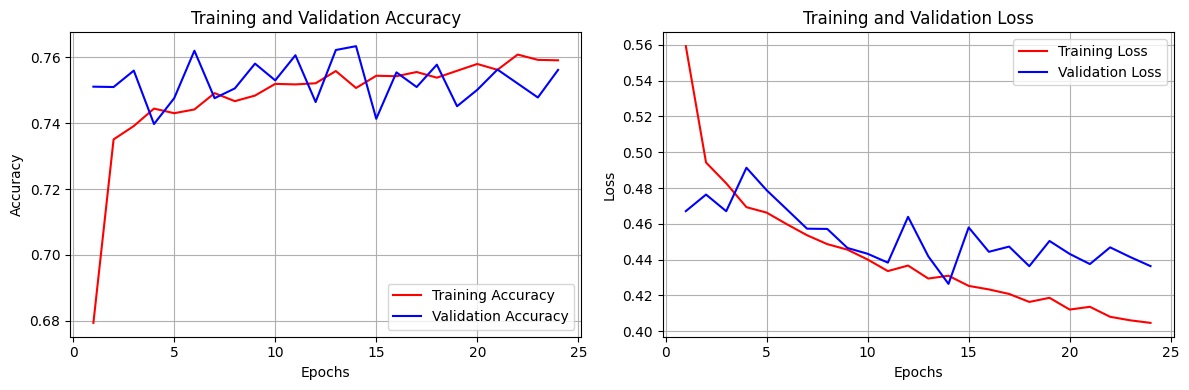

In [26]:
plot_learning_curves(history)

**DNN Model Evaluation**

In [27]:
# train and test predictions
dnn_y_test_pred = model.predict(X_test_scaled)
dnn_y_train_pred = model.predict(X_train_scaled)

1180/1180 [==============================] - 2s 1ms/step


In [28]:
print(classification_report(y_test, dnn_y_test_pred.round()))

              precision    recall  f1-score   support

         0.0       0.97      0.75      0.85     10463
         1.0       0.30      0.82      0.44      1333

    accuracy                           0.76     11796
   macro avg       0.63      0.79      0.64     11796
weighted avg       0.89      0.76      0.80     11796



In [29]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dnn_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dnn_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

78.75% - Balanced accuracy Test
82.24% - Balanced accuracy Train


In [31]:
evaluate_classification(model, X_test_scaled, y_test)

369/369 [==============================] - 1s 1ms/step
AUC: 0.86
Sensitivity: 0.82
Specificity: 0.75
Accuracy: 0.76
Balanced Accuracy: 0.79


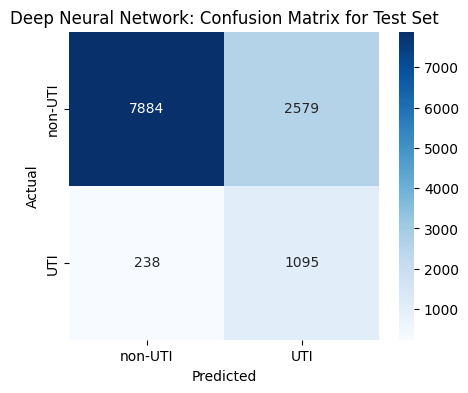

In [30]:
plot_confusion_matrix(y_test, dnn_y_test_pred.round(), title='Deep Neural Network: Confusion Matrix for Test Set')

369/369 [==============================] - 1s 1ms/step


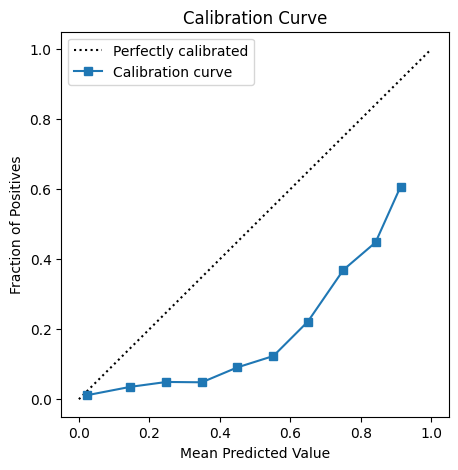

In [32]:
# calibration curve
dnn_y_test_pred = model.predict(X_test_scaled)
prob_true, prob_pred = calibration_curve(y_test, dnn_y_test_pred, n_bins=10, strategy='uniform')

plt.figure(figsize=(5, 5))
plt.plot([0, 1], [0, 1], 'k:', label='Perfectly calibrated')
plt.plot(prob_pred, prob_true, 's-', label='Calibration curve')
plt.ylabel('Fraction of Positives')
plt.xlabel('Mean Predicted Value')
plt.legend()
plt.title('Calibration Curve')
plt.show()

Perfectly Calibrated: In a perfectly calibrated model, the calibration curve would be a diagonal line, going from the bottom left corner to the top right corner of the plot (i.e., a 45-degree line, often labeled as "Perfectly calibrated").

Over-confident: If the curve is below the diagonal line, the model's predicted probabilities are generally higher than the actual fraction of positives, indicating over-confidence.

Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


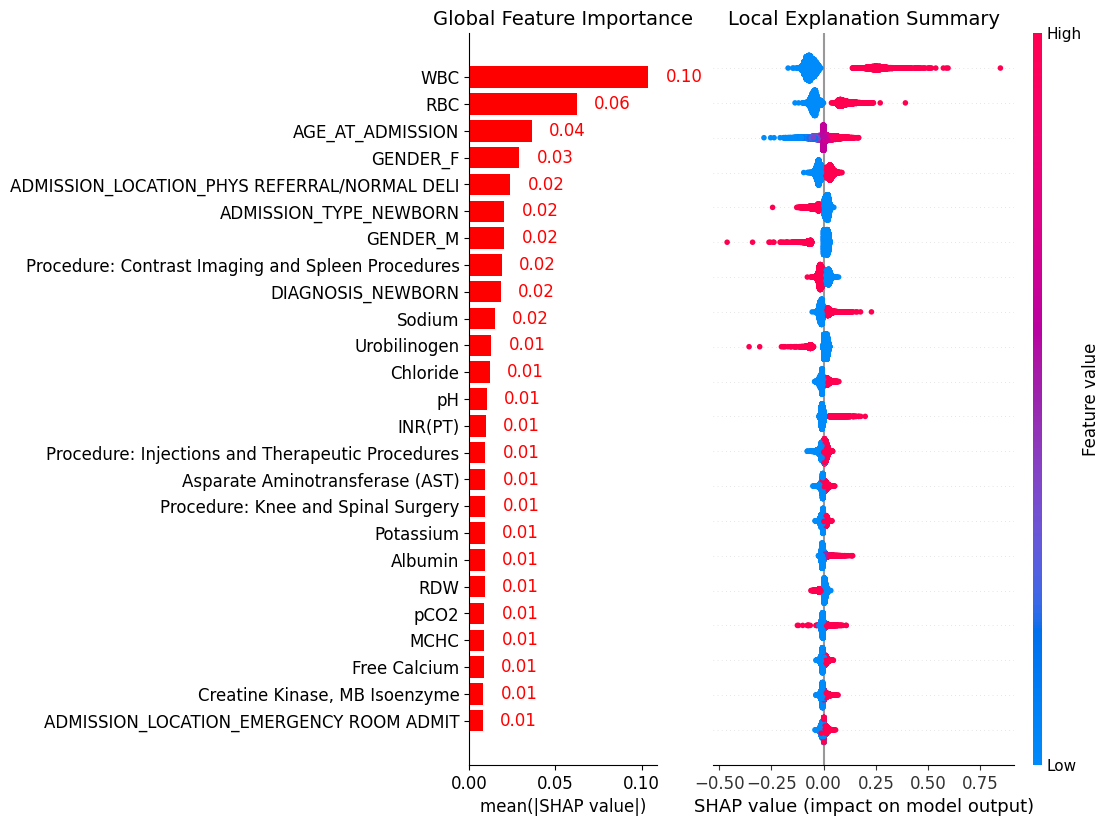

In [33]:
## SHAP

# Get feature names
feature_names = X.columns.tolist()

X_train_scaled = X_train_scaled.astype(np.float32)
random_indices = np.random.choice(X_train_scaled.shape[0], size=1000, replace=False)
subset_data = X_train_scaled[random_indices]

# Compute SHAP values for a particular set (e.g., test set)
# Using DeepExplainer for Deep Neural Network model:
explainer = shap.DeepExplainer(model, subset_data)
shap_values = explainer.shap_values(X_test_scaled)

# The first set of values from the list of shap_values for binary classification
shap_values_array = shap_values[0]

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-25:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[:, sorted_indices]

# Create a combined plot with subplots using GridSpec for layout
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)
ax1.set_title('Global Feature Importance', fontsize=14)
ax1.tick_params(axis='both', which='major', labelsize=12)
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar with red color
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)

# Plot typical SHAP values on right
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

## Attention with DNN

feed-forward neural network with an attention mechanism in the middle

- input layer
- 2 dense layer
- attention
- output layer

In [122]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Multiply, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.utils import compute_sample_weight

# Set seeds for reproducibility
np.random.seed(123)
tf.random.set_seed(123)

# Define the attention mechanism
def attention_mechanism(inputs, attention_size):
    hidden_layer = Dense(attention_size, activation='tanh')(inputs)
    attention_probs = Dense(inputs.shape[1], activation='softmax')(hidden_layer)
    attention_mul = Multiply()([inputs, attention_probs])
    return attention_mul

# Hyperparameters
input_dim = X_train_scaled.shape[1]
attention_size = 64
hidden_units = 256


# Model architecture
inputs = Input(shape=(input_dim,))

# First hidden layer
x = Dense(hidden_units, activation='swish')(inputs)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Second hidden layer
x = Dense(hidden_units, activation='swish')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)

# Third hidden layer
x = Dense(hidden_units, activation='swish')(x)
x = Dropout(0.3)(x)
x = BatchNormalization()(x)


x = attention_mechanism(x, attention_size)
x = Flatten()(x)
outputs = Dense(1, activation='sigmoid')(x)


model_attention = Model(inputs=inputs, outputs=outputs)

# Performance Scheduling callback
lr_scheduler = ReduceLROnPlateau(factor=0.5, patience=5)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
    lr_scheduler
]

optimizer = Adam(learning_rate=0.001)
model_attention.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Compute sample weights for training data
sample_weights = compute_sample_weight(class_weight='balanced', y=y_train)

# Train the model with sample weights and callbacks
history_attention = model_attention.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.1,
    sample_weight=sample_weights,
    callbacks=callbacks
)


Epoch 1/100
1059/1062 [============================>.] - ETA: 0s - loss: 0.5547 - accuracy: 0.7146

1062/1062 [==============================] - 11s 6ms/step - loss: 0.5550 - accuracy: 0.7146 - val_loss: 0.4675 - val_accuracy: 0.7473 - lr: 0.0010
Epoch 2/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4989 - accuracy: 0.7601

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4989 - accuracy: 0.7601 - val_loss: 0.4615 - val_accuracy: 0.7685 - lr: 0.0010
Epoch 3/100
1056/1062 [============================>.] - ETA: 0s - loss: 0.4880 - accuracy: 0.7683

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4879 - accuracy: 0.7684 - val_loss: 0.4552 - val_accuracy: 0.7711 - lr: 0.0010
Epoch 4/100
1060/1062 [============================>.] - ETA: 0s - loss: 0.4821 - accuracy: 0.7629

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4823 - accuracy: 0.7629 - val_loss: 0.4495 - val_accuracy: 0.7380 - lr: 0.0010
Epoch 5/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4741 - accuracy: 0.7660

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4740 - accuracy: 0.7659 - val_loss: 0.4600 - val_accuracy: 0.7677 - lr: 0.0010
Epoch 6/100
1057/1062 [============================>.] - ETA: 0s - loss: 0.4716 - accuracy: 0.7676

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4718 - accuracy: 0.7676 - val_loss: 0.4589 - val_accuracy: 0.7608 - lr: 0.0010
Epoch 7/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4640 - accuracy: 0.7783

1062/1062 [==============================] - 7s 6ms/step - loss: 0.4640 - accuracy: 0.7783 - val_loss: 0.4501 - val_accuracy: 0.7788 - lr: 0.0010
Epoch 8/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4616 - accuracy: 0.7703

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4616 - accuracy: 0.7703 - val_loss: 0.4495 - val_accuracy: 0.7634 - lr: 0.0010
Epoch 9/100
1056/1062 [============================>.] - ETA: 0s - loss: 0.4582 - accuracy: 0.7667

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4586 - accuracy: 0.7669 - val_loss: 0.4519 - val_accuracy: 0.7589 - lr: 0.0010
Epoch 10/100
1057/1062 [============================>.] - ETA: 0s - loss: 0.4459 - accuracy: 0.7764

1062/1062 [==============================] - 7s 6ms/step - loss: 0.4460 - accuracy: 0.7766 - val_loss: 0.4429 - val_accuracy: 0.7746 - lr: 5.0000e-04
Epoch 11/100
1057/1062 [============================>.] - ETA: 0s - loss: 0.4405 - accuracy: 0.7814

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4405 - accuracy: 0.7814 - val_loss: 0.4470 - val_accuracy: 0.7775 - lr: 5.0000e-04
Epoch 12/100
1059/1062 [============================>.] - ETA: 0s - loss: 0.4376 - accuracy: 0.7838

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4379 - accuracy: 0.7838 - val_loss: 0.4449 - val_accuracy: 0.7732 - lr: 5.0000e-04
Epoch 13/100
1056/1062 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.7794

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4343 - accuracy: 0.7791 - val_loss: 0.4479 - val_accuracy: 0.7584 - lr: 5.0000e-04
Epoch 14/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.7765

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4247 - accuracy: 0.7765 - val_loss: 0.4475 - val_accuracy: 0.7669 - lr: 5.0000e-04
Epoch 15/100
1054/1062 [============================>.] - ETA: 0s - loss: 0.4263 - accuracy: 0.7836

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4264 - accuracy: 0.7834 - val_loss: 0.4466 - val_accuracy: 0.7759 - lr: 5.0000e-04
Epoch 16/100
1059/1062 [============================>.] - ETA: 0s - loss: 0.4160 - accuracy: 0.7789

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4159 - accuracy: 0.7789 - val_loss: 0.4475 - val_accuracy: 0.7772 - lr: 2.5000e-04
Epoch 17/100
1062/1062 [==============================] - ETA: 0s - loss: 0.4140 - accuracy: 0.7800

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4140 - accuracy: 0.7800 - val_loss: 0.4486 - val_accuracy: 0.7793 - lr: 2.5000e-04
Epoch 18/100
1058/1062 [============================>.] - ETA: 0s - loss: 0.4090 - accuracy: 0.7831

1062/1062 [==============================] - 7s 6ms/step - loss: 0.4087 - accuracy: 0.7831 - val_loss: 0.4551 - val_accuracy: 0.7852 - lr: 2.5000e-04
Epoch 19/100
1056/1062 [============================>.] - ETA: 0s - loss: 0.4097 - accuracy: 0.7832

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4093 - accuracy: 0.7832 - val_loss: 0.4566 - val_accuracy: 0.7923 - lr: 2.5000e-04
Epoch 20/100
1057/1062 [============================>.] - ETA: 0s - loss: 0.4071 - accuracy: 0.7909

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4082 - accuracy: 0.7908 - val_loss: 0.4533 - val_accuracy: 0.7899 - lr: 2.5000e-04
Epoch 21/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.4040 - accuracy: 0.7927

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4040 - accuracy: 0.7927 - val_loss: 0.4564 - val_accuracy: 0.7881 - lr: 1.2500e-04
Epoch 22/100
1058/1062 [============================>.] - ETA: 0s - loss: 0.4042 - accuracy: 0.7938

1062/1062 [==============================] - 6s 6ms/step - loss: 0.4039 - accuracy: 0.7938 - val_loss: 0.4595 - val_accuracy: 0.7918 - lr: 1.2500e-04
Epoch 23/100
1061/1062 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.7964

1062/1062 [==============================] - 6s 6ms/step - loss: 0.3975 - accuracy: 0.7965 - val_loss: 0.4609 - val_accuracy: 0.7955 - lr: 1.2500e-04
Epoch 24/100
1059/1062 [============================>.] - ETA: 0s - loss: 0.3967 - accuracy: 0.7982

1062/1062 [==============================] - 6s 6ms/step - loss: 0.3969 - accuracy: 0.7981 - val_loss: 0.4602 - val_accuracy: 0.7918 - lr: 1.2500e-04
Epoch 25/100
1057/1062 [============================>.] - ETA: 0s - loss: 0.3949 - accuracy: 0.7986

1062/1062 [==============================] - 6s 6ms/step - loss: 0.3948 - accuracy: 0.7986 - val_loss: 0.4636 - val_accuracy: 0.7921 - lr: 1.2500e-04


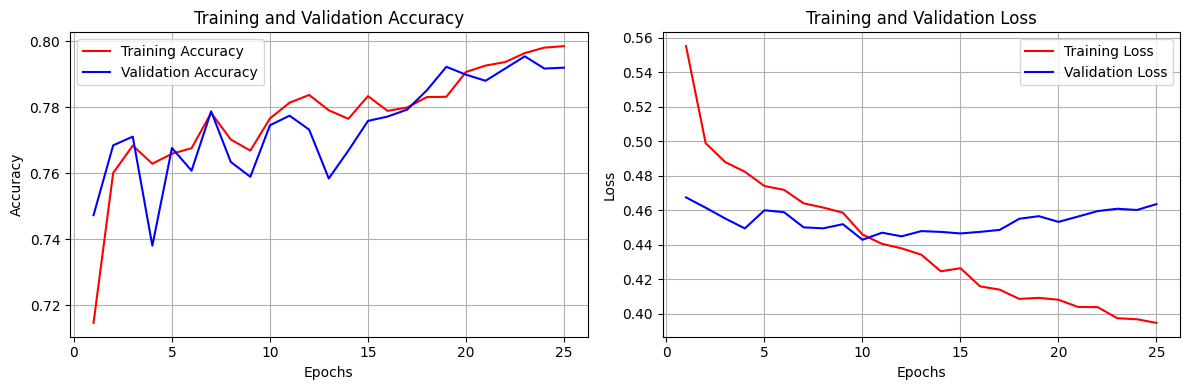

In [123]:
plot_learning_curves(history_attention)

In [124]:
# train and test predictions
attention_y_test_pred = model_attention.predict(X_test_scaled)
attention_y_train_pred = model_attention.predict(X_train_scaled)

print(classification_report(y_test, attention_y_test_pred.round()))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, attention_y_test_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, attention_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")



1180/1180 [==============================] - 2s 2ms/step
              precision    recall  f1-score   support

         0.0       0.97      0.78      0.87     10463
         1.0       0.32      0.79      0.45      1333

    accuracy                           0.78     11796
   macro avg       0.64      0.79      0.66     11796
weighted avg       0.89      0.78      0.82     11796

78.78% - Balanced accuracy Test
80.16% - Balanced accuracy Train


In [125]:
evaluate_classification(model_attention, X_test_scaled, y_test)

369/369 [==============================] - 1s 2ms/step
AUC: 0.86
Sensitivity: 0.79
Specificity: 0.78
Accuracy: 0.78
Balanced Accuracy: 0.79


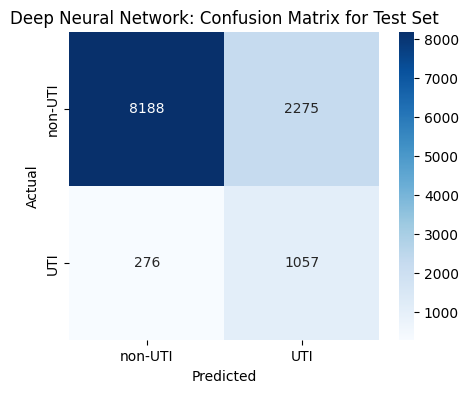

In [126]:
plot_confusion_matrix(y_test, attention_y_test_pred.round(), title='Deep Neural Network: Confusion Matrix for Test Set')

## Decision Tree

In [78]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, balanced_accuracy_score

# Initialize the DecisionTreeClassifier with the best parameters
dt = DecisionTreeClassifier(
    max_depth=10,
    min_samples_leaf=5,
    min_samples_split=2,
    random_state=42,
    class_weight='balanced'
)
dt.fit(X_train_scaled, y_train)

# Predictions
dt_y_pred = dt.predict(X_test_scaled)
dt_y_train_pred = dt.predict(X_train_scaled)

# Print classification report
print(classification_report(y_test, dt_y_pred))

# Calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, dt_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, dt_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")


              precision    recall  f1-score   support

         0.0       0.96      0.76      0.85     10463
         1.0       0.28      0.73      0.41      1333

    accuracy                           0.76     11796
   macro avg       0.62      0.75      0.63     11796
weighted avg       0.88      0.76      0.80     11796

74.64% - Balanced accuracy Test
82.27% - Balanced accuracy Train


In [79]:
evaluate_classification(dt, X_test_scaled, y_test)

AUC: 0.78
Sensitivity: 0.73
Specificity: 0.76
Accuracy: 0.76
Balanced Accuracy: 0.75


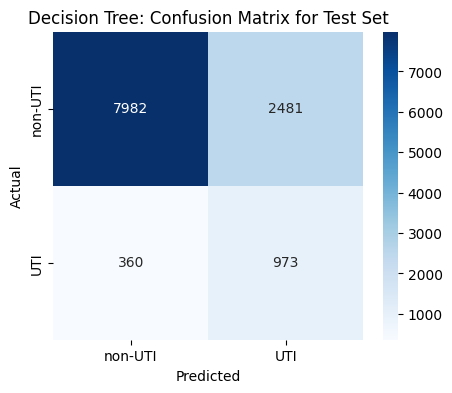

In [80]:
plot_confusion_matrix(y_test, dt_y_pred.round(), title='Decision Tree: Confusion Matrix for Test Set')

## Random Forest

In [41]:
# using the best parameters
best_param_rf = {'max_depth': 10,
 'min_samples_leaf': 5,
 'min_samples_split': 2,
 'n_estimators': 83}

rf = RandomForestClassifier(**best_param_rf,random_state=42, class_weight='balanced')
rf.fit(X_train_scaled, y_train)

rf_y_pred = rf.predict(X_test_scaled)
rf_y_train_pred = rf.predict(X_train_scaled)
print(classification_report(y_test, rf_y_pred))

# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, rf_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, rf_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     10463
         1.0       0.33      0.76      0.46      1333

    accuracy                           0.80     11796
   macro avg       0.65      0.78      0.67     11796
weighted avg       0.89      0.80      0.83     11796

78.44% - Balanced accuracy Test
82.39% - Balanced accuracy Train


In [43]:
evaluate_classification(rf, X_test_scaled, y_test)

AUC: 0.86
Sensitivity: 0.76
Specificity: 0.81
Accuracy: 0.80
Balanced Accuracy: 0.78


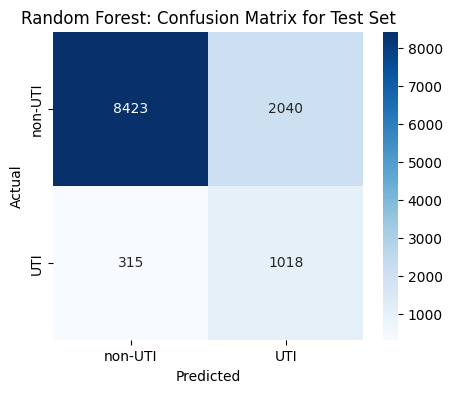

In [42]:
plot_confusion_matrix(y_test, rf_y_pred.round(), title='Random Forest: Confusion Matrix for Test Set')

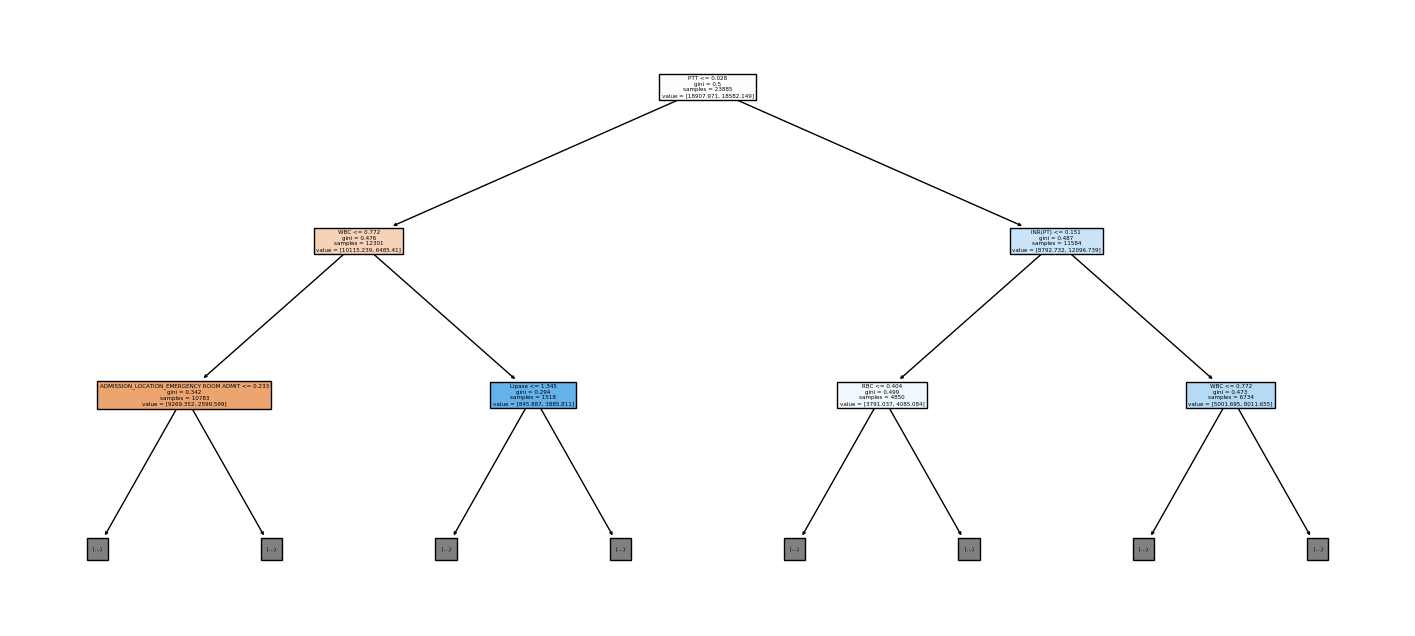

In [44]:
# Visualizing the first decision tree
plt.figure(figsize=(18,8))
plot_tree(rf.estimators_[0], filled=True, max_depth=2, feature_names=X.columns)
plt.show()

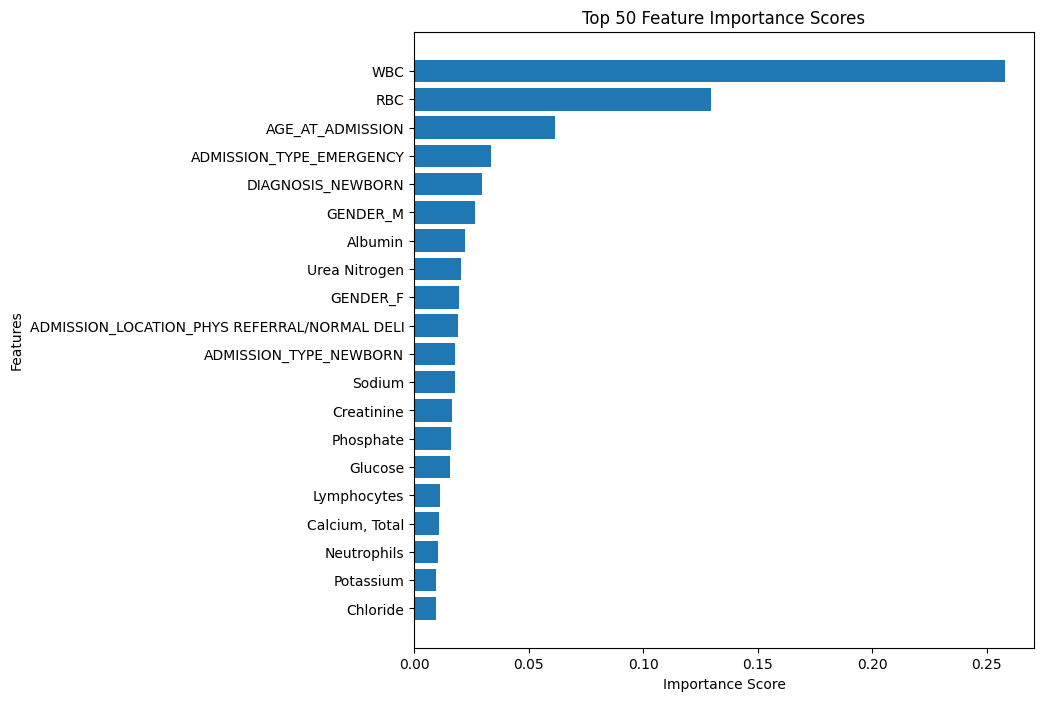

In [45]:
importances = rf.feature_importances_
features = X.columns

# Get the indices of the top features
sorted_indices = np.argsort(importances)[-20:]

plt.figure(figsize=(8,8))
plt.barh(features[sorted_indices], importances[sorted_indices])
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.title('Top 50 Feature Importance Scores')
plt.show()


Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


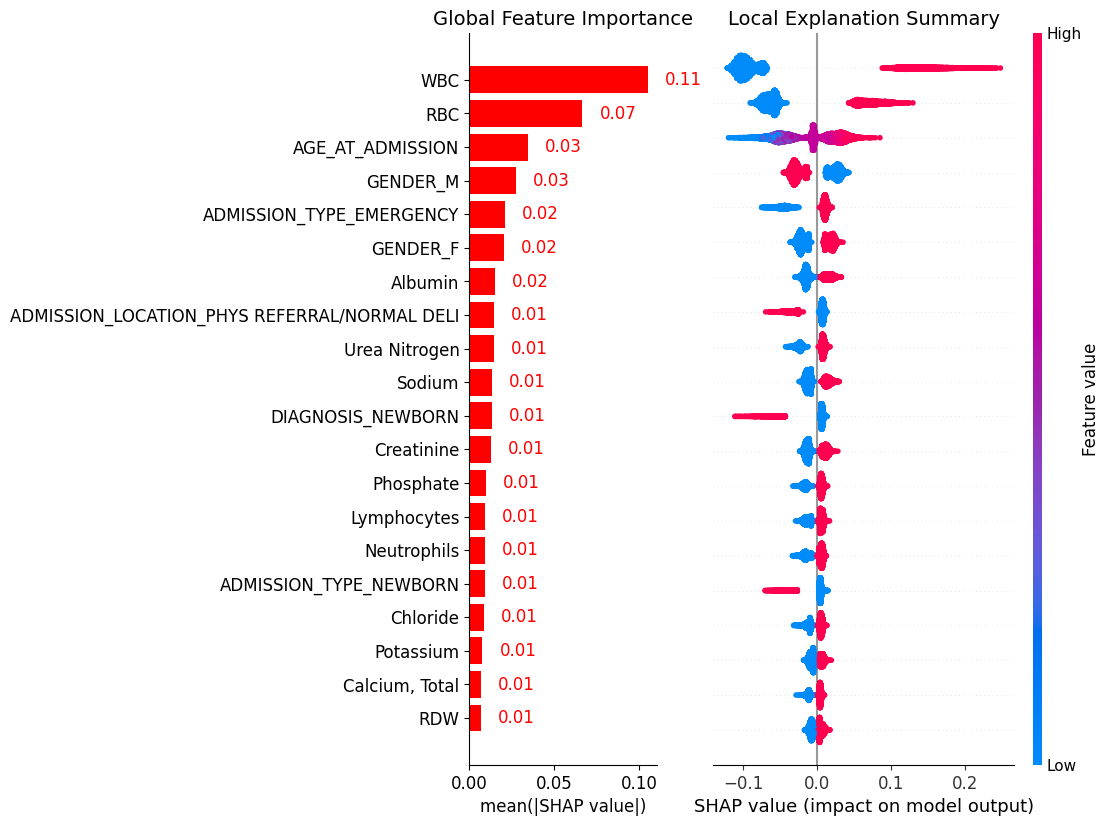

In [92]:
# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object
explainer = shap.TreeExplainer(rf)

# Compute SHAP values for a particular set (e.g., test set)
shap_values = explainer.shap_values(X_test_scaled)

# If your problem is binary classification, shap_values will be a list where [0] is for class 0 and [1] is for class 1.
# We often care about the SHAP values for the positive class
if isinstance(shap_values, list):
    shap_values_array = shap_values[1]
else:
    shap_values_array = shap_values

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[top_features]

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)  # Adjust font size
ax1.set_title('Global Feature Importance', fontsize=14)  # Adjust font size
ax1.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Remove the top and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)  # Adjust font size

# Plot typical SHAP values on right using only the top features
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)  # Add title and adjust font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Turn off y-axis ticks and labels for ax2 (SHAP dot plot)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

## XGBoost

In [48]:
# XGBoost best hyperparameters
best_params_xgb_binlog = {'learning_rate': 0.07333333333333333, 'max_depth': 3, 'n_estimators': 450}

# amend for class imbalances
class_weights = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# run on best parameters
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42, **best_params_xgb_binlog, scale_pos_weight=class_weights)
xgb_model.fit(X_train_scaled, y_train)

# predict using test set
xgb_predictions = xgb_model.predict(X_test_scaled)
xgb_train_predictions = xgb_model.predict(X_train_scaled)

# show classification report
print("XGBoost Classification Report:\n")
print(classification_report(y_test, xgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, xgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, xgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

XGBoost Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.32      0.79      0.45      1333

    accuracy                           0.79     11796
   macro avg       0.64      0.79      0.66     11796
weighted avg       0.89      0.79      0.82     11796

78.71% - Balanced accuracy Test
80.14% - Balanced accuracy Train


In [50]:
evaluate_classification(xgb_model, X_test_scaled, y_test)

AUC: 0.86
Sensitivity: 0.79
Specificity: 0.79
Accuracy: 0.79
Balanced Accuracy: 0.79


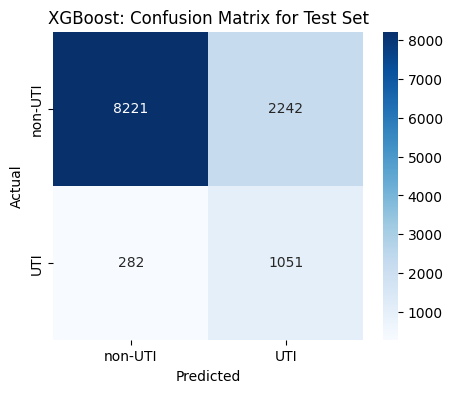

In [49]:
plot_confusion_matrix(y_test, xgb_predictions.round(), title='XGBoost: Confusion Matrix for Test Set')

## LightGBM

Optuna Hyperparameter Search

In [54]:
# LightGBM best hyperparameters
best_params = {'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'metric': 'binary_logloss',
 'min_child_samples': 30,
 'num_leaves': 50,
 'objective': 'binary'}

# fit model with best parameters
lgb_best = lgb.LGBMClassifier(**best_params, scale_pos_weight=class_weights, random_state=42)
lgb_best.fit(X_train_scaled, y_train)

# predict using test set
lgb_predictions = lgb_best.predict(X_test_scaled)
lgb_train_predictions = lgb_best.predict(X_train_scaled)

# show classification report
print("LightGBM Classification Report:\n")
print(classification_report(y_test, lgb_predictions))

# show balanced accuracy
print(f"{balanced_accuracy_score(y_test, lgb_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, lgb_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

[LightGBM] [Info] Number of positive: 4167, number of negative: 33577
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006462 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 380
[LightGBM] [Info] Number of data points in the train set: 37744, number of used features: 80
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.110402 -> initscore=-2.086645
[LightGBM] [Info] Start training from score -2.086645
LightGBM Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.81      0.88     10463
         1.0       0.34      0.76      0.47      1333

    accuracy                           0.81     11796
   macro avg       0.65      0.79      0.68     11796
weighted avg       0.89      0.81      0.84     11796

78.61% - Balanced accuracy Test
87.46% - Balanced accuracy Train


In [56]:
evaluate_classification(lgb_best, X_test_scaled, y_test)

AUC: 0.86
Sensitivity: 0.76
Specificity: 0.81
Accuracy: 0.81
Balanced Accuracy: 0.79


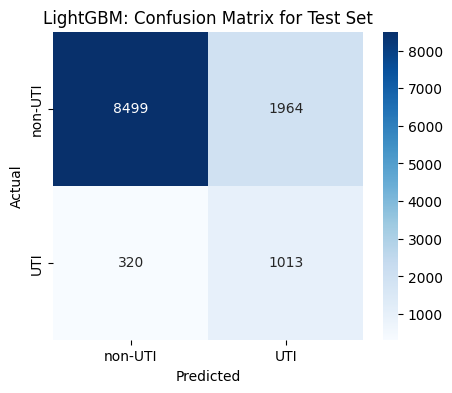

In [55]:
plot_confusion_matrix(y_test, lgb_predictions.round(), title='LightGBM: Confusion Matrix for Test Set')

## SVM

In [83]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, balanced_accuracy_score

# Initialize the SVM classifier
# Note: SVMs can be sensitive to the choice of the kernel and other parameters.
# I'm using the RBF kernel as a starting point, but you might want to adjust this and other parameters.
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(X_train_scaled, y_train)

# Predictions
svm_y_pred = svm.predict(X_test_scaled)
svm_y_train_pred = svm.predict(X_train_scaled)

# Print classification report
print(classification_report(y_test, svm_y_pred))

# Calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, svm_y_pred.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, svm_y_train_pred.round()) * 100:.2f}% - Balanced accuracy Train")

              precision    recall  f1-score   support

         0.0       0.96      0.84      0.89     10463
         1.0       0.36      0.70      0.47      1333

    accuracy                           0.82     11796
   macro avg       0.66      0.77      0.68     11796
weighted avg       0.89      0.82      0.85     11796

76.89% - Balanced accuracy Test
90.57% - Balanced accuracy Train


In [85]:
evaluate_classification(svm, X_test_scaled, y_test)

AUC: 0.77
Sensitivity: 0.70
Specificity: 0.84
Accuracy: 0.82
Balanced Accuracy: 0.77


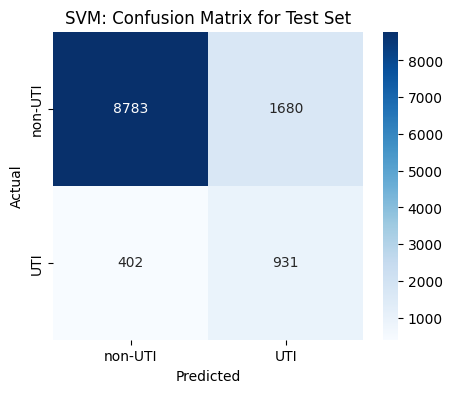

In [84]:
plot_confusion_matrix(y_test, svm_y_pred.round(), title='SVM: Confusion Matrix for Test Set')

## Logistic Regression

In [58]:
# Create and train the model with balanced class weights and increased iterations
logistic_model = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
logistic_model.fit(X_train_scaled, y_train)

# Predict using test set
logistic_predictions = logistic_model.predict(X_test_scaled)
logistic_train_predictions = logistic_model.predict(X_train_scaled)

# Show classification report
print("Logistic Regression Classification Report:\n")
print(classification_report(y_test, logistic_predictions))


Logistic Regression Classification Report:

              precision    recall  f1-score   support

         0.0       0.97      0.79      0.87     10463
         1.0       0.32      0.79      0.46      1333

    accuracy                           0.79     11796
   macro avg       0.65      0.79      0.66     11796
weighted avg       0.89      0.79      0.82     11796



In [59]:
# calculate balanced accuracy
print(f"{balanced_accuracy_score(y_test, logistic_predictions.round()) * 100:.2f}% - Balanced accuracy Test")
print(f"{balanced_accuracy_score(y_train, logistic_train_predictions.round()) * 100:.2f}% - Balanced accuracy Train")

78.90% - Balanced accuracy Test
78.06% - Balanced accuracy Train


In [61]:
evaluate_classification(logistic_model, X_test_scaled, y_test)

AUC: 0.86
Sensitivity: 0.79
Specificity: 0.79
Accuracy: 0.79
Balanced Accuracy: 0.79


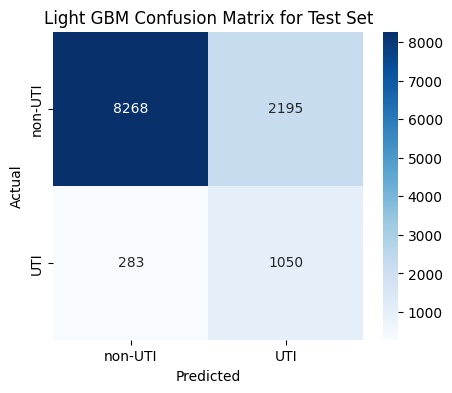

In [60]:
plot_confusion_matrix(y_test, logistic_predictions.round(), title='Light GBM Confusion Matrix for Test Set')

**SHAP (SHapley Additive exPlanations)**

Explain the output of machine learning models and identifying feature importance by using Shapley values to fairly allocate contributions of each feature for individual predictions.

Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations


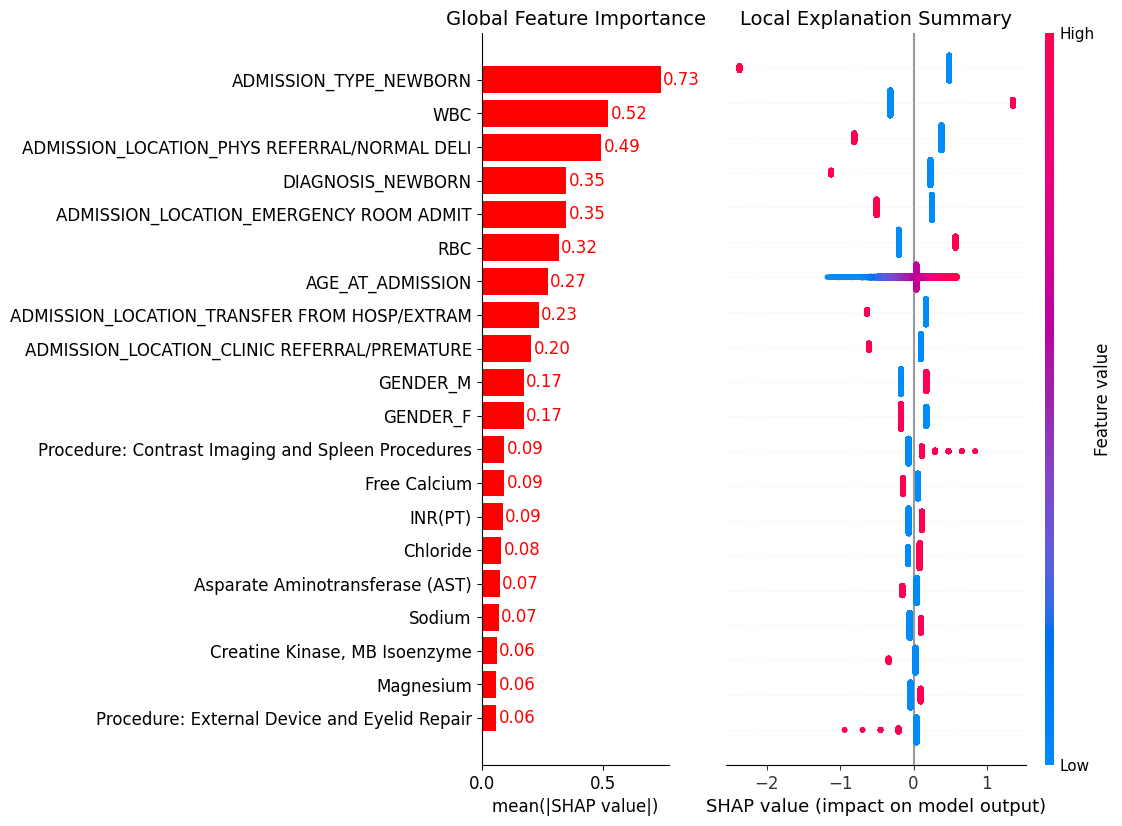

In [62]:
# Get feature names
feature_names = X.columns.tolist()

# # Convert training and test sets to DataFrames with those feature names
X_train_scaled = pd.DataFrame(X_train_scaled, columns=feature_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=feature_names)

# Initialize the explainer object with the appropriate masker
masker = shap.maskers.Independent(data=X_train_scaled)
explainer = shap.LinearExplainer(logistic_model, masker=masker)

# Compute SHAP values for a particular set (e.g., test set)
shap_values_obj = explainer(X_test_scaled)

# Extract values from the Explanation object
shap_values_array = shap_values_obj.values

# Calculate mean absolute SHAP values for global importance
global_shap_vals = np.abs(shap_values_array).mean(axis=0)

# Sort features based on their global importance
sorted_indices = np.argsort(global_shap_vals)[-20:]
top_features = np.array(feature_names)[sorted_indices]
top_global_shap_vals = global_shap_vals[sorted_indices]

# Subset the data and SHAP values for top features
top_shap_values = shap_values_array[:, sorted_indices]
X_test_top_features = X_test_scaled[top_features]

# Plot global importance of top features on left
ax1 = plt.subplot(gs[0])
bars = ax1.barh(top_features, top_global_shap_vals, color='red')
ax1.set_xlabel('mean(|SHAP value|)', fontsize=12)  # Adjust font size
ax1.set_title('Global Feature Importance', fontsize=14)  # Adjust font size
ax1.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Remove the top and right spines
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# Add values beside the bar
for bar in bars:
    ax1.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{bar.get_width():.2f}',
             va='center', ha='left', color='red', fontsize=12)  # Adjust font size

# Plot typical SHAP values on right using only the top features
ax2 = plt.subplot(gs[1])
shap.summary_plot(top_shap_values, X_test_top_features, feature_names=top_features, plot_type="dot", show=False)
ax2.set_title('Local Explanation Summary', fontsize=14)  # Add title and adjust font size
ax2.tick_params(axis='both', which='major', labelsize=12)  # Adjust tick font size

# Turn off y-axis ticks and labels for ax2 (SHAP dot plot)
ax2.set_yticks([])
ax2.set_yticklabels([])

plt.show()

Red: Feature has a high value for that observation

Blue: Feature has a low value for that observation

Position on the x-axis: Indicates the effect of that value on the output


Feature importance based on SHAP-values. On the left side, the mean absolute SHAP values are depicted, to illustrate global feature importance. On the right side, the local explanation summary shows the direction of the relationship between a variable and target output. Positive SHAP-values are indicative of uti, while negative SHAP-values are indicative of non-uti. As demonstrated by the colorbar, higher values are shown in red, while lower values are shown in blue.

## ROC Curve for all models

369/369 [==============================] - 1s 2ms/step


X has feature names, but RandomForestClassifier was fitted without feature names
X has feature names, but LogisticRegression was fitted without feature names


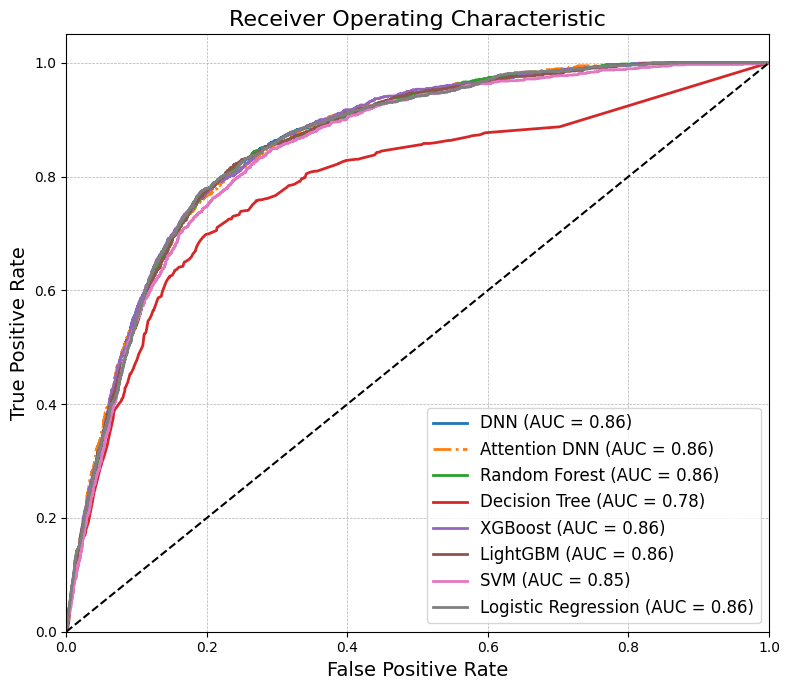

In [88]:
# For DNN
y_pred_dnn = model.predict(X_test_scaled).ravel()
fpr_dnn, tpr_dnn, thresholds_dnn = roc_curve(y_test, y_pred_dnn)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

# For Attention DNN
y_pred_attention = model_attention.predict(X_test_scaled).ravel()
fpr_attention, tpr_attention, thresholds_attention = roc_curve(y_test, y_pred_attention)
roc_auc_attention = auc(fpr_attention, tpr_attention)

# For Decision Trees
y_pred_dt = dt.predict_proba(X_test_scaled)[:, 1]
fpr_dt, tpr_dt, thresholds_dt = roc_curve(y_test, y_pred_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# For Random Forest
y_pred_rf = rf.predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# For XGBoost
y_pred_xgb = xgb_model.predict_proba(X_test_scaled)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_test, y_pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# For LightGBM
y_pred_lgb = lgb_best.predict_proba(X_test_scaled)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_test, y_pred_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# For SVM
y_pred_svm = svm.decision_function(X_test_scaled)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_pred_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# For Logistic Regression
y_pred_logistic = logistic_model.predict_proba(X_test_scaled)[:, 1]
fpr_logistic, tpr_logistic, thresholds_logistic = roc_curve(y_test, y_pred_logistic)
roc_auc_logistic = auc(fpr_logistic, tpr_logistic)

# Plotting
plt.figure(figsize=(8, 7))  # Increase the figure size for better visibility

# Increase line width for better visibility and label them appropriately
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {roc_auc_dnn:.2f})', linewidth=2)
plt.plot(fpr_attention, tpr_attention, label=f'Attention DNN (AUC = {roc_auc_attention:.2f})', linewidth=2, linestyle='-.')  # Changed linestyle for differentiation
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})', linewidth=2)
plt.plot(fpr_dt, tpr_dt, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})', linewidth=2)
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})', linewidth=2)
plt.plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC = {roc_auc_lgb:.2f})', linewidth=2)
plt.plot(fpr_svm, tpr_svm, label=f'SVM (AUC = {roc_auc_svm:.2f})', linewidth=2)
plt.plot(fpr_logistic, tpr_logistic, label=f'Logistic Regression (AUC = {roc_auc_logistic:.2f})', linewidth=2)

# Diagonal dashed line
plt.plot([0, 1], [0, 1], 'k--', linewidth=1.5)

# Set the x and y limits, labels, title and legend
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic', fontsize=16)
plt.legend(loc="lower right", fontsize=12)

# Improve aesthetics
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()

plt.show()


Best Model =

## Risk Scores

X has feature names, but RandomForestClassifier was fitted without feature names


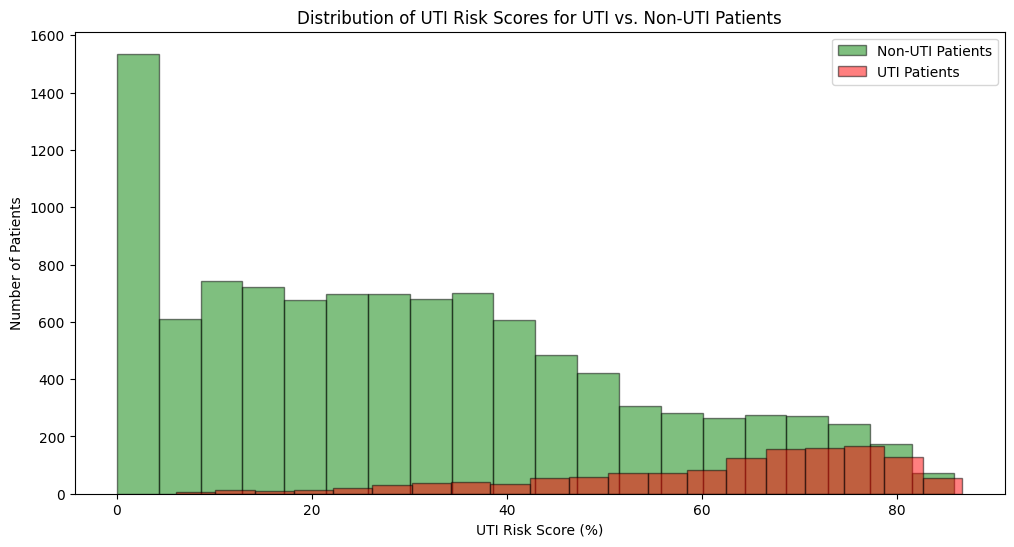

In [77]:
# Predict probabilities
probabilities = rf.predict_proba(X_test_scaled)

# Extract uti risk scores
uti_risk_scores = probabilities[:, 1]
uti_risk_scores_percentage = uti_risk_scores * 100

uti_scores = uti_risk_scores_percentage[y_test == 1]
non_uti_scores = uti_risk_scores_percentage[y_test == 0]

plt.figure(figsize=(12,6))

# Histogram for non-UTI patients
plt.hist(non_uti_scores, bins=20, color='green', alpha=0.5, label='Non-UTI Patients', edgecolor='black')

# Histogram for UTI patients
plt.hist(uti_scores, bins=20, color='red', alpha=0.5, label='UTI Patients', edgecolor='black')

plt.xlabel('UTI Risk Score (%)')
plt.ylabel('Number of Patients')
plt.title('Distribution of UTI Risk Scores for UTI vs. Non-UTI Patients')
plt.legend()
plt.show()


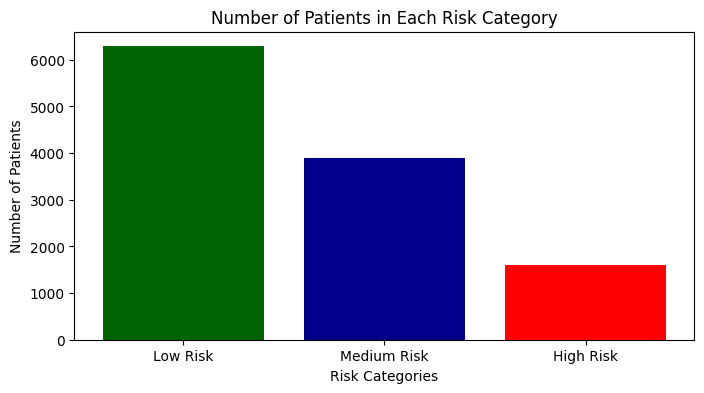

In [65]:
# Risk Categories
categories = ['Low Risk', 'Medium Risk', 'High Risk']
counts = [
    sum(uti_risk_scores_percentage <= 33),
    sum((uti_risk_scores_percentage > 33) & (uti_risk_scores_percentage <= 66)),
    sum(uti_risk_scores_percentage > 66)
]

plt.figure(figsize=(8,4))
plt.bar(categories, counts, color=['darkgreen', 'darkblue', 'red'])
plt.xlabel('Risk Categories')
plt.ylabel('Number of Patients')
plt.title('Number of Patients in Each Risk Category')
plt.show()


## Patient Journey: Plotting Risk Over Time

Plotting Risk Over Time

In [31]:
import gdown
import pandas as pd

url = "https://drive.google.com/uc?id=1gbCOuChLORE3MadTQhqspibN0-_H_546"
output = "ffill_new.csv"
gdown.download(url, output, quiet=False)

ffill_new = pd.read_csv(output)
ffill_new.shape

Downloading...
From: https://drive.google.com/uc?id=1gbCOuChLORE3MadTQhqspibN0-_H_546
To: /content/ffill_new.csv
100%|██████████| 874M/874M [00:03<00:00, 277MB/s]


(2482473, 83)

In [67]:
# Store the TIMESTAMP for later use
timestamps = ffill_new["TIMESTAMP"].copy()
hadmid = ffill_new["HADM_ID"].copy()

# Drop the TIMESTAMP column from the data
ffill_new = ffill_new.drop(columns="TIMESTAMP")
ffill_new = ffill_new.drop(columns="HADM_ID")
ffill_new = ffill_new.drop(columns="uti")

# Now, scale the data
timestamp_scaled = StdScaler.transform(ffill_new)

In [68]:
# Predict to get risk scores
risk_scores = model_attention.predict(timestamp_scaled)
ffill_new["Risk_Scores"] = risk_scores

77578/77578 [==============================] - 129s 2ms/step


In [69]:
# Add the TIMESTAMP column back to new_data
ffill_new["TIMESTAMP"] = timestamps
ffill_new["HADM_ID"] = hadmid

# Filter out rows for a specific ID
sample_HADM_ID = 108957
sample_data = ffill_new[ffill_new['HADM_ID'] == sample_HADM_ID]

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`


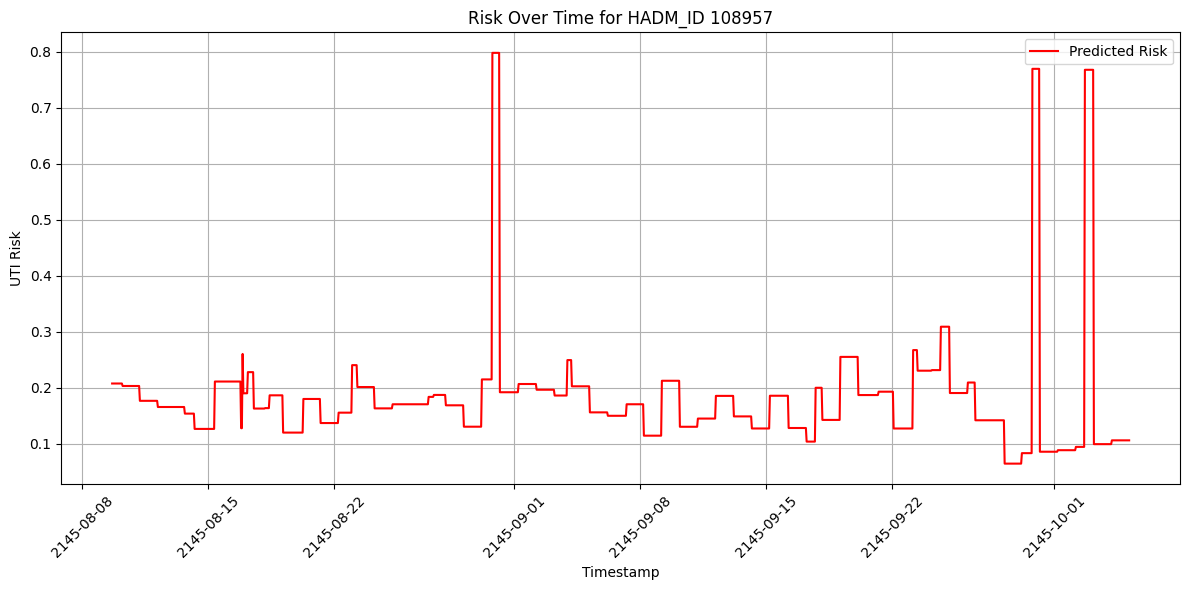

In [71]:
# Reset style to default
plt.style.use('default')

# Convert TIMESTAMP column to datetime
sample_data = sample_data.copy()
sample_data.loc[:, "TIMESTAMP"] = pd.to_datetime(sample_data["TIMESTAMP"])

# Plotting the risk over time
plt.figure(figsize=(12, 6))
plt.plot(sample_data["TIMESTAMP"], sample_data["Risk_Scores"], label='Predicted Risk', color='red')
plt.title(f'Risk Over Time for HADM_ID {sample_HADM_ID}')
plt.xlabel('Timestamp')
plt.ylabel('UTI Risk')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  # Rotate timestamps for better visibility
plt.tight_layout()
plt.show()


In [72]:
# Select data between 08-28 and 09-01
selected_data = sample_data[(sample_data['TIMESTAMP'] >= '2145-08-30 18:00:00') & (sample_data['TIMESTAMP'] <= '2145-08-31 07:00:00')]
selected_data

,Procedure: Surgical Suture and Repair,"Creatine Kinase, MB Isoenzyme",Bands,Lipase,Iron,Procedure: Facial and Thoracic Surgery,"Bilirubin, Total",Procedure: Cranial and Peripheral Interventions,Eosinophils,"Fibrinogen, Functional",ADMISSION_TYPE_ELECTIVE,"Chloride, Whole Blood",Procedure: External Device and Eyelid Repair,"Iron Binding Capacity, Total",Red Blood Cells,Procedure: Gastric Procedure and Vascular Revision,"Sodium, Whole Blood",Monocytes,Transferrin,ADMISSION_LOCATION_TRANSFER FROM HOSP/EXTRAM,Hematocrit,Procedure: Spinal and Abdominal Surgery,Vancomycin,ADMISSION_LOCATION_CLINIC REFERRAL/PREMATURE,Alanine Aminotransferase (ALT),Procedure: Structural and Bone Biopsy,Procedure: Lung Biopsy and Intervention,"Potassium, Whole Blood",ADMISSION_TYPE_NEWBORN,Lactate Dehydrogenase (LD),pCO2,Urobilinogen,pO2,Procedure: Arterial Imaging and Debridement,pH,Anion Gap,Asparate Aminotransferase (AST),Free Calcium,Calculated Total CO2,ETHNICITY_WHITE,PT,Alkaline Phosphatase,Lactate,DIAGNOSIS_NEWBORN,Procedure: Knee and Spinal Surgery,MCV,ADMISSION_LOCATION_PHYS REFERRAL/NORMAL DELI,White Blood Cells,Hyaline Casts,Platelet Count,MCH,ADMISSION_LOCATION_EMERGENCY ROOM ADMIT,RDW,MCHC,INR(PT),Magnesium,Creatine Kinase (CK),Neutrophils,Lymphocytes,Bicarbonate,Procedure: Injections and Therapeutic Procedures,"Calcium, Total",Glucose,Potassium,PTT,Procedure: Catheterization and Ventilation Techniques,Troponin T,Procedure: Contrast Imaging and Spleen Procedures,Phosphate,Chloride,Sodium,Albumin,Creatinine,GENDER_F,Urea Nitrogen,GENDER_M,ADMISSION_TYPE_EMERGENCY,AGE_AT_ADMISSION,RBC,WBC,Risk_Scores,TIMESTAMP,HADM_ID
215673,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,0.0,0.0,0.215286,2145-08-30 18:00:00,108957
215674,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.798291,2145-08-30 19:00:00,108957
215675,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.798291,2145-08-30 20:00:00,108957
215676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.798291,2145-08-30 21:00:00,108957
215677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.798291,2145-08-30 22:00:00,108957
215678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,57.0,1.0,1.0,0.798291,2145-08-30 23:00:00,108957
215679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,

The risk for the patient notably spiked during the same period when both  the White Blood Cell (WBC) and Red Blood Cell (RBC) were recorded as 1 during the timeframe from approximately 2145-08-30 19:00:00 to 2145-08-31 04:00:00.

#LSTM